In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing classifiers
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [3]:
#Importing benchmark tools
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [4]:
data = pd.read_csv("training_frame.csv").iloc[:,2:]
data = data.drop("patient_id",1)
data = data.drop("machine_id",1)
data

,heart_rate,respiration_over_impedence,spirometry_oxygen_saturation,pulse,blood_pressure_systolic,blood_pressure_diastolic,blood_pressure_average,Coded
0,111.0,44.0,100.0,110.0,111.0,74.0,79.0,0.0
1,85.0,12.0,97.0,92.0,95.0,60.0,77.0,0.0
2,92.0,6.0,99.0,92.0,113.0,71.0,93.0,0.0
3,64.0,22.0,96.0,65.0,128.0,80.0,88.0,0.0
4,111.0,22.0,96.0,102.0,100.0,64.0,72.0,0.0
...,...,...,...,...,...,...,...,...
99995,152.0,46.0,96.0,115.0,122.0,80.0,88.0,1.0
99996,152.0,46.0,96.0,115.0,122.0,80.0,88.0,1.0
99997,128.0,22.0,100.0,126.0,185.0,157.0,167.0,1.0
99998,128.0,22.0,100.0,126.0,185.0,157.0,167.0,1.0


### Normalize data

In [5]:
# data = (data-data.min())/(data.max()-data.min())
# data

## Feature selection using correlation matrix

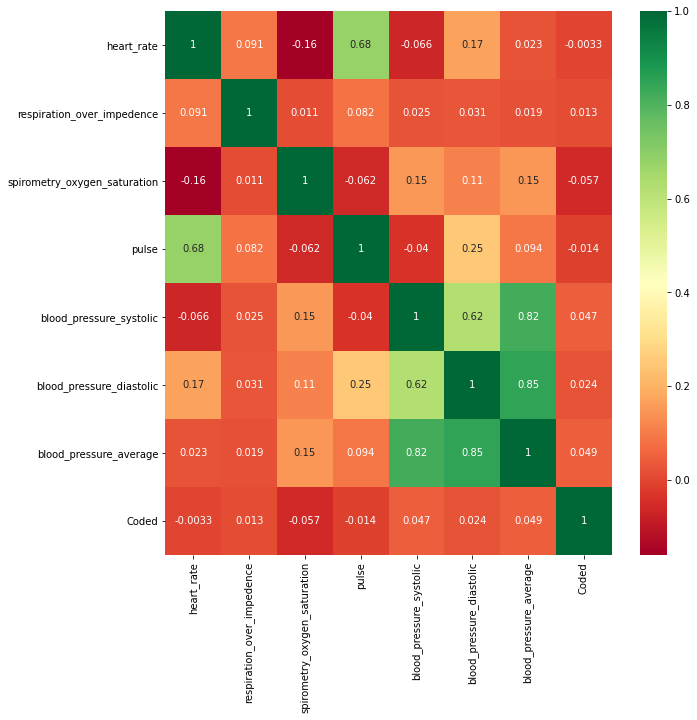

In [6]:
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

bp systolic, diastolic and average are correlated up to 80%.
This means we can choose one of them.
Heart rate and Pulse are correlated up to 68% but as it doesn't meet usual threshold of 80% I have decided to keep them as is.

## Making train data and loading test data

In [7]:
X_train = data.drop(['blood_pressure_systolic', "blood_pressure_diastolic", "Coded"], axis=1)
y_train = data.iloc[:,-1]
X_train

,heart_rate,respiration_over_impedence,spirometry_oxygen_saturation,pulse,blood_pressure_average
0,111.0,44.0,100.0,110.0,79.0
1,85.0,12.0,97.0,92.0,77.0
2,92.0,6.0,99.0,92.0,93.0
3,64.0,22.0,96.0,65.0,88.0
4,111.0,22.0,96.0,102.0,72.0
...,...,...,...,...,...
99995,152.0,46.0,96.0,115.0,88.0
99996,152.0,46.0,96.0,115.0,88.0
99997,128.0,22.0,100.0,126.0,167.0
99998,128.0,22.0,100.0,126.0,167.0


### Finding Aggregate of test data by patient_id and day

In [8]:
test_data = pd.read_csv("test_frame.csv").iloc[:, 1:]
test_data["vitals_datetime"] = pd.to_datetime(test_data["vitals_datetime"])
data_agg = test_data.groupby(["patient_id", test_data["vitals_datetime"].dt.date]).agg({"heart_rate":'mean',
                                                                          "respiration_over_impedence":'mean',
                                                                          "spirometry_oxygen_saturation":'mean',
                                                                          "pulse":'mean',
                                                                          "blood_pressure_average":'mean',
                                                                          "Coded":'max'})

### Setting all events with dates that has at least 1 codeblue as high risk events

In [9]:
high_risk = [0]*len(data_agg)

#find high risk dates
high_risk_dates = []
for i in range(len(data_agg)):
    if(data_agg.loc[data_agg.index[i]].Coded == 1):
        if data_agg.index[i][1] not in high_risk_dates:
            high_risk_dates.append(data_agg.index[i][1])

#set high_risk corresponding to all records in data_agg
for i in range(len(data_agg)):
    if(data_agg.index[i][1] in high_risk_dates):
        high_risk[i] = 1
    

data_agg['high_risk'] = high_risk

X_test = data_agg.reset_index().iloc[:,2:-2]
y_test = data_agg.reset_index().iloc[:,-2]

## Naive Bayes Classifier

In [10]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

In [11]:
#Benchmarking
accuracy_nb = accuracy_score(y_test, y_pred)

print("\nClassification report : \n ", classification_report(y_test,y_pred))
print("\nConfusion matrix : \n", confusion_matrix(y_test,y_pred))


Classification report : 
                precision    recall  f1-score   support

         0.0       0.93      1.00      0.96       326
         1.0       0.00      0.00      0.00        25

    accuracy                           0.93       351
   macro avg       0.46      0.50      0.48       351
weighted avg       0.86      0.93      0.89       351


Confusion matrix : 
 [[326   0]
 [ 25   0]]


## Ridge Classifier

In [12]:
#Train and predict
regr = RidgeClassifier(random_state=42)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

In [13]:
#Benchmarking
accuracy_regr = accuracy_score(y_test, y_pred)

print("\nClassification report : \n ", classification_report(y_test,y_pred))
print("\nConfusion matrix : \n", confusion_matrix(y_test,y_pred))


Classification report : 
                precision    recall  f1-score   support

         0.0       0.93      1.00      0.96       326
         1.0       0.00      0.00      0.00        25

    accuracy                           0.93       351
   macro avg       0.46      0.50      0.48       351
weighted avg       0.86      0.93      0.89       351


Confusion matrix : 
 [[326   0]
 [ 25   0]]


## Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(max_depth=10, n_estimators=100, max_features=2)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [15]:
#Benchmarking
accuracy_clf = accuracy_score(y_test, y_pred)

print("\nClassification report : \n ", classification_report(y_test,y_pred))
print("\nConfusion matrix : \n", confusion_matrix(y_test,y_pred))


Classification report : 
                precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       326
         1.0       0.00      0.00      0.00        25

    accuracy                           0.89       351
   macro avg       0.46      0.48      0.47       351
weighted avg       0.86      0.89      0.87       351


Confusion matrix : 
 [[311  15]
 [ 25   0]]


## Comparing results of different classification algorithms 

In [16]:
Algorithms = ['Naive Bayes', 'Ridge', 'Random Forest'] #x-axis of bar graphs
c = ['Pink', 'Orange', 'Cyan'] #color scheme

### Accuracy Comparison

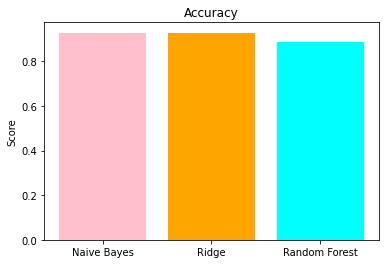

Accuracy:  [0.9287749287749287, 0.9287749287749287, 0.886039886039886]


In [17]:
score = [accuracy_nb, accuracy_regr, accuracy_clf] #y-axis

plt.bar(Algorithms, score, color=c)
plt.title("Accuracy")
plt.ylabel('Score')
plt.show()
print("Accuracy: ", score)